In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [2]:
import os
import pathlib
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Bidirectional, Dense, \
 AdditiveAttention, LayerNormalization, Add

from math import inf
from tqdm import tqdm

## Define all paths relevant for this project

In [3]:
project_dir = "/content/drive/MyDrive/Projects/Suvidha-Foundation-Internship-Project"

In [4]:
train_file_path = os.path.join(project_dir, 'data/preprocessed/finished_files/final_train.csv')
val_file_path = os.path.join(project_dir, 'data/preprocessed/finished_files/final_val.csv')
test_file_path = os.path.join(project_dir, 'data/preprocessed/finished_files/final_test.csv')

## Preparing Data for Model Experiement and for Actual Training

### Load the data from CSV file and according save it inside contexts and targets

In [5]:
def load_data(path):
  data = pd.read_csv(path)
  articles, summaries = data['article'].to_numpy(), data['highlights'].to_numpy()

  return articles, summaries

In [6]:
train_articles_raw, train_summaries_raw = load_data(train_file_path)
val_articles_raw, val_summaries_raw = load_data(val_file_path)
test_articles_raw, test_summaries_raw = load_data(test_file_path)

In [7]:
len(train_articles_raw)

287113

In [8]:
train_articles_raw[0]

"by . associated press . published : . 14:11 est , 25 october 2013 . | . updated : . 15:36 est , 25 october 2013 . the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo , grand forks and jamestown to the hepatitis a virus in late september and early october . the state health department has issued an advisory of exposure for anyone who attended five churches and took communion . bishop john folda ( pictured ) of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo , grand forks and jamestown to the hepatitis a . state immunization program manager molly howell says the risk is low , but officials feel it 's important to alert people to the possible exposure . the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a . the diocese says he contracted the infection through contaminated food while attending a conference for n

### Create experimental tf dataset

Using tf.data with csv files - [Tensorflow Tutorial Link](https://www.tensorflow.org/tutorials/load_data/csv#using_tfdata).

Creating train_ds, val_ds and test_ds using tf.data.Dataset - [Tensorflow Tutorial Link](https://www.tensorflow.org/text/tutorials/nmt_with_attention#create_a_tfdata_dataset).

In [9]:
train_raw = tf.data.Dataset \
            .from_tensor_slices((train_articles_raw, train_summaries_raw))

val_raw = tf.data.Dataset \
          .from_tensor_slices((val_articles_raw, val_summaries_raw))

test_raw = tf.data.Dataset \
          .from_tensor_slices((test_articles_raw, test_summaries_raw))

In [10]:
for example_article_string, example_summary_string in train_raw.take(1):
  print(example_article_string)
  print()
  print(example_summary_string)
  break

tf.Tensor(b"by . associated press . published : . 14:11 est , 25 october 2013 . | . updated : . 15:36 est , 25 october 2013 . the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo , grand forks and jamestown to the hepatitis a virus in late september and early october . the state health department has issued an advisory of exposure for anyone who attended five churches and took communion . bishop john folda ( pictured ) of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo , grand forks and jamestown to the hepatitis a . state immunization program manager molly howell says the risk is low , but officials feel it 's important to alert people to the possible exposure . the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a . the diocese says he contracted the infection through contaminated food while attending a confe

### Vocabulary Loading

In [11]:
# Retrieve the vocabularies using the vocab file
with open(os.path.join(project_dir, 'data/preprocessed/finished_files/vocab'), 'r') as reader:
  vocab = reader.read()

In [12]:
vocab[:20]

'. 12012810\nthe 11803'

In [13]:
[v.split(' ')[0] for v in vocab.split('\n')[:5]]

['.', 'the', ',', 'to', 'a']

In [14]:
vocab_data = [v.split(' ')[0] for v in vocab.split('\n')]

In [15]:
# In the vocabolary we already have the masked token, so we need to remove it
# otherwise TextVectorization would give ValuesError
vocab_data.index('')

200000

In [16]:
vocab_data.remove('')

In [17]:
# Add it to the vocab_data as well as to all the texts
vocab_data.insert(0, '[START]')
vocab_data.insert(1, '[END]')

### Text Tokenizer

In [18]:
# As we do not have [START] and [END] included in our context or target,
# let's include them in a function and pass it to the TextVectorization
def add_start_end(text):
  # If already any [START] or [END] token is present, remove them
  text = tf.strings.regex_replace(text, '[START]', '')
  text = tf.strings.regex_replace(text, '[END]', '')

  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')

  return text

In [19]:
example_text = tf.constant('how are you ?')
print(example_text)
print(example_text.numpy().decode())
print(add_start_end(example_text).numpy().decode())

tf.Tensor(b'how are you ?', shape=(), dtype=string)
how are you ?
[START] how are you ? [END]


In [20]:
vocab_data[:10]

['[START]', '[END]', '.', 'the', ',', 'to', 'a', 'and', 'of', 'in']

In [21]:
max_article_tokens = 400 # From the paper
max_summary_tokens = 100 # From the paper

article_vocab_size = 50000
summary_vocab_size = 50000

article_processor = TextVectorization(max_tokens=article_vocab_size+2, # 2 extra for '', [UNK]
                                   standardize=add_start_end,
                                   vocabulary=vocab_data[:article_vocab_size],
                                   output_sequence_length = max_article_tokens)

summary_processor = TextVectorization(max_tokens=summary_vocab_size+2, # 2 extra for '', [UNK]
                                   standardize=add_start_end,
                                   vocabulary=vocab_data[:summary_vocab_size],
                                   output_sequence_length = max_summary_tokens)

In [22]:
article_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', ',', 'to', 'a', 'and']

In [23]:
example_article_string

<tf.Tensor: shape=(), dtype=string, numpy=b"by . associated press . published : . 14:11 est , 25 october 2013 . | . updated : . 15:36 est , 25 october 2013 . the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo , grand forks and jamestown to the hepatitis a virus in late september and early october . the state health department has issued an advisory of exposure for anyone who attended five churches and took communion . bishop john folda ( pictured ) of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo , grand forks and jamestown to the hepatitis a . state immunization program manager molly howell says the risk is low , but officials feel it 's important to alert people to the possible exposure . the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a . the diocese says he contracted the infection through contamina

In [24]:
example_article_token = article_processor(example_article_string)
example_article_token

<tf.Tensor: shape=(400,), dtype=int64, numpy=
array([    2,    28,     4,  1579,   673,     4,   263,    23,     4,
       48259,   179,     6,   712,   519,   202,     4,   393,     4,
         331,    23,     4,     1,   179,     6,   712,   519,   202,
           4,     5,  4273,    10,     5, 15991,  3060, 14346,    11,
         294,  6146,    32,  2727,  2367,   919,    10,   833,   342,
          11, 15991,     6,  1028, 28440,     9, 36041,     7,     5,
       13753,     8,  2080,    11,   554,   491,     9,   365,   519,
           4,     5,   164,   259,   409,    32,  1250,    41,  7558,
          10,  4374,    13,   713,    44,  1634,   218,  6880,     9,
         195, 21741,     4,  4273,   364,     1,    54,   205,    53,
          10,     5, 15991,  3060, 14346,    11,   294,  6146,    32,
        2727,  2367,   919,    10,   833,   342,    11, 15991,     6,
        1028, 28440,     9, 36041,     7,     5, 13753,     8,     4,
         164, 32830,   913,   544,  9407, 14

In [25]:
summary_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', ',', 'to', 'a', 'and']

In [26]:
example_summary_string

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] bishop john folda , of north dakota , is taking time off after being diagnosed . he contracted the infection through contaminated food in italy . church members in fargo , grand forks and jamestown could have been exposed . [END]'>

In [27]:
example_summary_token = summary_processor(example_summary_string)
example_summary_token

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([    2,     1,  4273,   364,     1,     6,    10,   294,  6146,
           6,    17,   345,    82,   129,    46,   101,  1781,     4,
          18,  6119,     5,  2678,   144,  6719,   424,    11,  1296,
           4,   833,   342,    11, 15991,     6,  1028, 28440,     9,
       36041,    87,    30,    48,  2727,     4,     1,     3,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])>

### OOV (Out of Vocabulary) tokens

#### Finding OOVs from articles and maximum oovs in a batch

In [42]:
words = tf.strings.split(example_article_string, sep=' ')

words

<tf.Tensor: shape=(219,), dtype=string, numpy=
array([b'by', b'.', b'associated', b'press', b'.', b'published', b':',
       b'.', b'14:11', b'est', b',', b'25', b'october', b'2013', b'.',
       b'|', b'.', b'updated', b':', b'.', b'15:36', b'est', b',', b'25',
       b'october', b'2013', b'.', b'the', b'bishop', b'of', b'the',
       b'fargo', b'catholic', b'diocese', b'in', b'north', b'dakota',
       b'has', b'exposed', b'potentially', b'hundreds', b'of', b'church',
       b'members', b'in', b'fargo', b',', b'grand', b'forks', b'and',
       b'jamestown', b'to', b'the', b'hepatitis', b'a', b'virus', b'in',
       b'late', b'september', b'and', b'early', b'october', b'.', b'the',
       b'state', b'health', b'department', b'has', b'issued', b'an',
       b'advisory', b'of', b'exposure', b'for', b'anyone', b'who',
       b'attended', b'five', b'churches', b'and', b'took', b'communion',
       b'.', b'bishop', b'john', b'folda', b'(', b'pictured', b')', b'of',
       b'the', b'fargo',

In [43]:
if words.shape[0] > max_article_tokens-2:
  words = tf.slice(words, [0], [max_article_tokens-2])
else:
  paddings = [[0, (max_article_tokens - 2) - tf.shape(words)[0]]]
  words = tf.pad(words, paddings, constant_values='')

words

<tf.Tensor: shape=(398,), dtype=string, numpy=
array([b'by', b'.', b'associated', b'press', b'.', b'published', b':',
       b'.', b'14:11', b'est', b',', b'25', b'october', b'2013', b'.',
       b'|', b'.', b'updated', b':', b'.', b'15:36', b'est', b',', b'25',
       b'october', b'2013', b'.', b'the', b'bishop', b'of', b'the',
       b'fargo', b'catholic', b'diocese', b'in', b'north', b'dakota',
       b'has', b'exposed', b'potentially', b'hundreds', b'of', b'church',
       b'members', b'in', b'fargo', b',', b'grand', b'forks', b'and',
       b'jamestown', b'to', b'the', b'hepatitis', b'a', b'virus', b'in',
       b'late', b'september', b'and', b'early', b'october', b'.', b'the',
       b'state', b'health', b'department', b'has', b'issued', b'an',
       b'advisory', b'of', b'exposure', b'for', b'anyone', b'who',
       b'attended', b'five', b'churches', b'and', b'took', b'communion',
       b'.', b'bishop', b'john', b'folda', b'(', b'pictured', b')', b'of',
       b'the', b'fargo',

In [44]:
word2id = tf.keras.layers.StringLookup(mask_token='',
                                      oov_token="[UNK]",
                                      vocabulary=summary_processor.get_vocabulary())

In [45]:
tokens = word2id(words)

In [46]:
tokens

<tf.Tensor: shape=(398,), dtype=int64, numpy=
array([   28,     4,  1579,   673,     4,   263,    23,     4, 48259,
         179,     6,   712,   519,   202,     4,   393,     4,   331,
          23,     4,     1,   179,     6,   712,   519,   202,     4,
           5,  4273,    10,     5, 15991,  3060, 14346,    11,   294,
        6146,    32,  2727,  2367,   919,    10,   833,   342,    11,
       15991,     6,  1028, 28440,     9, 36041,     7,     5, 13753,
           8,  2080,    11,   554,   491,     9,   365,   519,     4,
           5,   164,   259,   409,    32,  1250,    41,  7558,    10,
        4374,    13,   713,    44,  1634,   218,  6880,     9,   195,
       21741,     4,  4273,   364,     1,    54,   205,    53,    10,
           5, 15991,  3060, 14346,    11,   294,  6146,    32,  2727,
        2367,   919,    10,   833,   342,    11, 15991,     6,  1028,
       28440,     9, 36041,     7,     5, 13753,     8,     4,   164,
       32830,   913,   544,  9407, 14201,   

In [47]:
words

<tf.Tensor: shape=(398,), dtype=string, numpy=
array([b'by', b'.', b'associated', b'press', b'.', b'published', b':',
       b'.', b'14:11', b'est', b',', b'25', b'october', b'2013', b'.',
       b'|', b'.', b'updated', b':', b'.', b'15:36', b'est', b',', b'25',
       b'october', b'2013', b'.', b'the', b'bishop', b'of', b'the',
       b'fargo', b'catholic', b'diocese', b'in', b'north', b'dakota',
       b'has', b'exposed', b'potentially', b'hundreds', b'of', b'church',
       b'members', b'in', b'fargo', b',', b'grand', b'forks', b'and',
       b'jamestown', b'to', b'the', b'hepatitis', b'a', b'virus', b'in',
       b'late', b'september', b'and', b'early', b'october', b'.', b'the',
       b'state', b'health', b'department', b'has', b'issued', b'an',
       b'advisory', b'of', b'exposure', b'for', b'anyone', b'who',
       b'attended', b'five', b'churches', b'and', b'took', b'communion',
       b'.', b'bishop', b'john', b'folda', b'(', b'pictured', b')', b'of',
       b'the', b'fargo',

In [48]:
tokens == 1

<tf.Tensor: shape=(398,), dtype=bool, numpy=
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, Fal

In [49]:
oovs = tf.boolean_mask(words, tf.equal(tokens, 1))

oovs

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'15:36', b'folda', b'folda'], dtype=object)>

In [50]:
tf.unique(oovs).y

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'15:36', b'folda'], dtype=object)>

In [51]:
oovs = tf.unique_with_counts(oovs).y
oovs_count = tf.unique_with_counts(oovs).y.shape[0]

oovs_count

2

#### Mapping article OOV words to indices and vice versa

In [52]:
tf.range(oovs_count, dtype=tf.int32)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 1], dtype=int32)>

In [53]:
vocab_size = summary_processor.vocabulary_size()

vocab_size

50002

In [54]:
vocab_size = tf.constant(vocab_size)

vocab_size

<tf.Tensor: shape=(), dtype=int32, numpy=50002>

In [55]:
values = tf.add(tf.range(oovs_count, dtype=tf.int32), vocab_size)

values

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([50002, 50003], dtype=int32)>

In [56]:
keys = oovs

keys

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'15:36', b'folda'], dtype=object)>

In [ ]:
init = tf.lookup.KeyValueTensorInitializer(keys, values)
oov_w2i = tf.lookup.StaticHashTable(init, default_value=1)
oov_w2i.lookup(tf.constant(b'folda'))

In [ ]:
init = tf.lookup.KeyValueTensorInitializer(values, keys)
oov_i2w = tf.lookup.StaticHashTable(init, default_value='[UNK]')
oov_i2w.lookup(tf.constant(50003))

<tf.Tensor: shape=(), dtype=string, numpy=b'folda'>

In [ ]:
oov_start_idx = vocab_size

oov_words = oovs
oov_ids = tf.add(tf.range(oovs_count, dtype=tf.int32), vocab_size)

init = tf.lookup.KeyValueTensorInitializer(oov_words, oov_ids)
oov_word2id = tf.lookup.StaticHashTable(init, default_value=1)

init = tf.lookup.KeyValueTensorInitializer(oov_ids, oov_words)
oov_id2word = tf.lookup.StaticHashTable(init, default_value='[UNK]')

In [ ]:
oov_word2id.lookup(tf.constant(b'folda'))

<tf.Tensor: shape=(), dtype=int32, numpy=50003>

#### Extend encoder vocab by updating UNK tokens with new OOV ids

In [ ]:
words = tf.strings.split(example_article_string, sep=' ')
word2id(words)

<tf.Tensor: shape=(219,), dtype=int64, numpy=
array([   28,     4,  1579,   673,     4,   263,    23,     4, 48259,
         179,     6,   712,   519,   202,     4,   393,     4,   331,
          23,     4,     1,   179,     6,   712,   519,   202,     4,
           5,  4273,    10,     5, 15991,  3060, 14346,    11,   294,
        6146,    32,  2727,  2367,   919,    10,   833,   342,    11,
       15991,     6,  1028, 28440,     9, 36041,     7,     5, 13753,
           8,  2080,    11,   554,   491,     9,   365,   519,     4,
           5,   164,   259,   409,    32,  1250,    41,  7558,    10,
        4374,    13,   713,    44,  1634,   218,  6880,     9,   195,
       21741,     4,  4273,   364,     1,    54,   205,    53,    10,
           5, 15991,  3060, 14346,    11,   294,  6146,    32,  2727,
        2367,   919,    10,   833,   342,    11, 15991,     6,  1028,
       28440,     9, 36041,     7,     5, 13753,     8,     4,   164,
       32830,   913,   544,  9407, 14201,   

In [ ]:
words = tf.keras.utils.pad_sequences([words],
                                     maxlen=max_article_tokens-2,
                                     padding="post",
                                     truncating="post",
                                     dtype=object,
                                     value='')

words

array([[b'by', b'.', b'associated', b'press', b'.', b'published', b':',
        b'.', b'14:11', b'est', b',', b'25', b'october', b'2013', b'.',
        b'|', b'.', b'updated', b':', b'.', b'15:36', b'est', b',',
        b'25', b'october', b'2013', b'.', b'the', b'bishop', b'of',
        b'the', b'fargo', b'catholic', b'diocese', b'in', b'north',
        b'dakota', b'has', b'exposed', b'potentially', b'hundreds',
        b'of', b'church', b'members', b'in', b'fargo', b',', b'grand',
        b'forks', b'and', b'jamestown', b'to', b'the', b'hepatitis',
        b'a', b'virus', b'in', b'late', b'september', b'and', b'early',
        b'october', b'.', b'the', b'state', b'health', b'department',
        b'has', b'issued', b'an', b'advisory', b'of', b'exposure',
        b'for', b'anyone', b'who', b'attended', b'five', b'churches',
        b'and', b'took', b'communion', b'.', b'bishop', b'john',
        b'folda', b'(', b'pictured', b')', b'of', b'the', b'fargo',
        b'catholic', b'diocese',

In [ ]:
tf.where(word2id(words)==1)

<tf.Tensor: shape=(3, 2), dtype=int64, numpy=
array([[  0,  20],
       [  0,  85],
       [  0, 150]])>

In [ ]:
words = tf.reshape(words, [-1])
words

<tf.Tensor: shape=(398,), dtype=string, numpy=
array([b'by', b'.', b'associated', b'press', b'.', b'published', b':',
       b'.', b'14:11', b'est', b',', b'25', b'october', b'2013', b'.',
       b'|', b'.', b'updated', b':', b'.', b'15:36', b'est', b',', b'25',
       b'october', b'2013', b'.', b'the', b'bishop', b'of', b'the',
       b'fargo', b'catholic', b'diocese', b'in', b'north', b'dakota',
       b'has', b'exposed', b'potentially', b'hundreds', b'of', b'church',
       b'members', b'in', b'fargo', b',', b'grand', b'forks', b'and',
       b'jamestown', b'to', b'the', b'hepatitis', b'a', b'virus', b'in',
       b'late', b'september', b'and', b'early', b'october', b'.', b'the',
       b'state', b'health', b'department', b'has', b'issued', b'an',
       b'advisory', b'of', b'exposure', b'for', b'anyone', b'who',
       b'attended', b'five', b'churches', b'and', b'took', b'communion',
       b'.', b'bishop', b'john', b'folda', b'(', b'pictured', b')', b'of',
       b'the', b'fargo',

In [ ]:
unk_ids = tf.where(word2id(words)==1)
unk_ids

<tf.Tensor: shape=(3, 1), dtype=int64, numpy=
array([[ 20],
       [ 85],
       [150]])>

In [ ]:
unk_words = tf.gather(words, unk_ids[:, 0])
unk_words

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'15:36', b'folda', b'folda'], dtype=object)>

In [ ]:
unk_tokens = oov_w2i.lookup(unk_words)
unk_tokens

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([50002, 50003, 50003], dtype=int32)>

In [ ]:
tokens = word2id(words)
tokens

<tf.Tensor: shape=(398,), dtype=int64, numpy=
array([   28,     4,  1579,   673,     4,   263,    23,     4, 48259,
         179,     6,   712,   519,   202,     4,   393,     4,   331,
          23,     4,     1,   179,     6,   712,   519,   202,     4,
           5,  4273,    10,     5, 15991,  3060, 14346,    11,   294,
        6146,    32,  2727,  2367,   919,    10,   833,   342,    11,
       15991,     6,  1028, 28440,     9, 36041,     7,     5, 13753,
           8,  2080,    11,   554,   491,     9,   365,   519,     4,
           5,   164,   259,   409,    32,  1250,    41,  7558,    10,
        4374,    13,   713,    44,  1634,   218,  6880,     9,   195,
       21741,     4,  4273,   364,     1,    54,   205,    53,    10,
           5, 15991,  3060, 14346,    11,   294,  6146,    32,  2727,
        2367,   919,    10,   833,   342,    11, 15991,     6,  1028,
       28440,     9, 36041,     7,     5, 13753,     8,     4,   164,
       32830,   913,   544,  9407, 14201,   

In [ ]:
unk_tokens = tf.cast(unk_tokens, tf.int64)

In [ ]:
unk_ids

<tf.Tensor: shape=(3, 1), dtype=int64, numpy=
array([[ 20],
       [ 85],
       [150]])>

In [ ]:
unk_tokens

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([50002, 50003, 50003])>

In [ ]:
oov_extended_encoder_in = tf.tensor_scatter_nd_update(tokens, unk_ids, unk_tokens)
oov_extended_encoder_in

<tf.Tensor: shape=(398,), dtype=int64, numpy=
array([   28,     4,  1579,   673,     4,   263,    23,     4, 48259,
         179,     6,   712,   519,   202,     4,   393,     4,   331,
          23,     4, 50002,   179,     6,   712,   519,   202,     4,
           5,  4273,    10,     5, 15991,  3060, 14346,    11,   294,
        6146,    32,  2727,  2367,   919,    10,   833,   342,    11,
       15991,     6,  1028, 28440,     9, 36041,     7,     5, 13753,
           8,  2080,    11,   554,   491,     9,   365,   519,     4,
           5,   164,   259,   409,    32,  1250,    41,  7558,    10,
        4374,    13,   713,    44,  1634,   218,  6880,     9,   195,
       21741,     4,  4273,   364, 50003,    54,   205,    53,    10,
           5, 15991,  3060, 14346,    11,   294,  6146,    32,  2727,
        2367,   919,    10,   833,   342,    11, 15991,     6,  1028,
       28440,     9, 36041,     7,     5, 13753,     8,     4,   164,
       32830,   913,   544,  9407, 14201,   

#### Finding the final distributions combining p_gen part and 1-p_gen part

In [ ]:
batch_size = example_tokens.shape[0]
extended_zeros = tf.zeros((batch_size, max_art_oov))

extended_zeros.shape

TensorShape([16, 17])

In [ ]:
# Dummy output value from the decoder which can be thought of Pvocab
P_vocab = tf.random.normal([batch_size, vocab_size])

In [ ]:
extended_vocab = tf.concat([P_vocab, extended_zeros], axis=1)

extended_vocab.shape

TensorShape([16, 50019])

In [ ]:
dummy_attention = tf.random.normal([batch_size, max_article_tokens])

dummy_attention.shape

TensorShape([16, 400])

In [ ]:
dummy_p_gen = tf.random.normal([batch_size, 1])

dummy_p_gen.shape

TensorShape([16, 1])

In [ ]:
generate_word_prob = dummy_p_gen * extended_vocab

generate_word_prob.shape

TensorShape([16, 50019])

In [ ]:
extended_vocab[0]

<tf.Tensor: shape=(50019,), dtype=float32, numpy=
array([-0.19701234,  0.49117807,  1.9465048 , ...,  0.        ,
        0.        ,  0.        ], dtype=float32)>

In [ ]:
tf.shape(enc_extended_vocab)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 16, 400], dtype=int32)>

In [ ]:
# Make the pair [0, 28] and like this for all 16X400 elements
list(enumerate(enc_extended_vocab))

[(0,
  <tf.Tensor: shape=(400,), dtype=int32, numpy=
  array([    2,    28,     4,  8504,  4611,     4,     8,  1529,    32,
           379,     5,   113, 11606, 50002,    11,   416,   349,    25,
            56,    10,   113,    74,  3150,  3750,     7,   150,   383,
            10,     5,   967,    31,    67,  2176,   619, 14913,     4,
           748,  6002,     6,   835,     6,    32,    48,  2308,    24,
          1663,    25,  1773, 20137, 50003,     9, 50004,   140,   491,
             4,    26,   191,    10,    24,  7056,   601,  2329,    25,
             5,  2310,     9, 50005, 10791,    11, 50006,     6,  4135,
             6,    18,    32,    98,  2008,    41,  2139,  4616,  7500,
            13,     8,   717,   692,    29,     5,  3818,    10,     5,
         50007,   276,    10, 50003,     4,  2350,    23,   748,  6002,
            54,   114,    53,    32,   379,    41, 11606, 50002,    25,
            56,    10,   113,    74,  3150,  3750,     7,   150,   383,
           

In [ ]:
[[batch_no, elm.numpy()] for batch_no, batch in list(enumerate(enc_extended_vocab)) for elm in batch]

[[0, 2],
 [0, 28],
 [0, 4],
 [0, 8504],
 [0, 4611],
 [0, 4],
 [0, 8],
 [0, 1529],
 [0, 32],
 [0, 379],
 [0, 5],
 [0, 113],
 [0, 11606],
 [0, 50002],
 [0, 11],
 [0, 416],
 [0, 349],
 [0, 25],
 [0, 56],
 [0, 10],
 [0, 113],
 [0, 74],
 [0, 3150],
 [0, 3750],
 [0, 7],
 [0, 150],
 [0, 383],
 [0, 10],
 [0, 5],
 [0, 967],
 [0, 31],
 [0, 67],
 [0, 2176],
 [0, 619],
 [0, 14913],
 [0, 4],
 [0, 748],
 [0, 6002],
 [0, 6],
 [0, 835],
 [0, 6],
 [0, 32],
 [0, 48],
 [0, 2308],
 [0, 24],
 [0, 1663],
 [0, 25],
 [0, 1773],
 [0, 20137],
 [0, 50003],
 [0, 9],
 [0, 50004],
 [0, 140],
 [0, 491],
 [0, 4],
 [0, 26],
 [0, 191],
 [0, 10],
 [0, 24],
 [0, 7056],
 [0, 601],
 [0, 2329],
 [0, 25],
 [0, 5],
 [0, 2310],
 [0, 9],
 [0, 50005],
 [0, 10791],
 [0, 11],
 [0, 50006],
 [0, 6],
 [0, 4135],
 [0, 6],
 [0, 18],
 [0, 32],
 [0, 98],
 [0, 2008],
 [0, 41],
 [0, 2139],
 [0, 4616],
 [0, 7500],
 [0, 13],
 [0, 8],
 [0, 717],
 [0, 692],
 [0, 29],
 [0, 5],
 [0, 3818],
 [0, 10],
 [0, 5],
 [0, 50007],
 [0, 276],
 [0, 10],
 [0

In [ ]:
indices = tf.constant([[batch_no, elm.numpy()]
                       for batch_no, batch in list(enumerate(enc_extended_vocab))
                       for elm in batch], dtype=tf.int64)

values = tf.ones(shape=(indices.shape[0]))

dense_shape = extended_vocab.shape

In [ ]:
sparse_unk = tf.SparseTensor(indices, values, dense_shape)
sparse_unk

SparseTensor(indices=tf.Tensor(
[[  0   2]
 [  0  28]
 [  0   4]
 ...
 [ 15   5]
 [ 15 107]
 [ 15   3]], shape=(6400, 2), dtype=int64), values=tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(6400,), dtype=float32), dense_shape=tf.Tensor([   16 50019], shape=(2,), dtype=int64))

In [ ]:
copy_word_prob = (1-dummy_p_gen)@tf.ones((1, dummy_attention.shape[1]))*dummy_attention

copy_word_prob.shape

TensorShape([16, 400])

In [ ]:
copy_word_prob[0, 3]

<tf.Tensor: shape=(), dtype=float32, numpy=-1.4672438>

In [ ]:
1 - dummy_p_gen[0, 0]

<tf.Tensor: shape=(), dtype=float32, numpy=1.6601427>

In [ ]:
(1 - dummy_p_gen[0, 0]) * dummy_attention[0, 3]

<tf.Tensor: shape=(), dtype=float32, numpy=-1.4672438>

In [ ]:
sparse_unk.values.shape

TensorShape([6400])

In [ ]:
indices = tf.constant([[batch_no, elm.numpy()]
                       for batch_no, batch in list(enumerate(enc_extended_vocab))
                       for elm in batch], dtype=tf.int64)

values = tf.reshape(copy_word_prob, [-1])
dense_shape = extended_vocab.shape

sparse_unk = tf.SparseTensor(indices, values, dense_shape)
sparse_unk

SparseTensor(indices=tf.Tensor(
[[  0   2]
 [  0  28]
 [  0   4]
 ...
 [ 15   5]
 [ 15 107]
 [ 15   3]], shape=(6400, 2), dtype=int64), values=tf.Tensor(
[-0.5758334   2.3832648   1.844269   ...  0.08851024 -0.40647966
  0.04801887], shape=(6400,), dtype=float32), dense_shape=tf.Tensor([   16 50019], shape=(2,), dtype=int64))

In [ ]:
dense_unk = tf.sparse.to_dense(sparse_unk, validate_indices=False)

dense_unk

<tf.Tensor: shape=(16, 50019), dtype=float32, numpy=
array([[ 0.        ,  0.        , -0.5758334 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -1.4551897 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.86349815, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        , -0.04558611, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -1.7585374 , ...,  1.2480762 ,
        -1.1533684 ,  2.144622  ],
       [ 0.        ,  0.        , -0.15936618, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)>

In [ ]:
copy_word_prob[3, 16]

<tf.Tensor: shape=(), dtype=float32, numpy=0.55988365>

In [ ]:
enc_extended_vocab[3, 16]

<tf.Tensor: shape=(), dtype=int32, numpy=487>

In [ ]:
dense_unk[3, 45]

<tf.Tensor: shape=(), dtype=float32, numpy=0.22178374>

In [ ]:
tensor1 = tf.random.normal(shape=[16, 100], dtype=tf.float32)
tensor2 = tf.random.normal(shape=[16, 100], dtype=tf.float64)

# tensor1 + tensor2 # Error as 2 are of different data types
tensor1 + tf.cast(tensor2, tf.float32) # Use tf.cast to first cast the values of 2nd tensor to float32

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-0.74156123,  0.56941223, -0.9034836 , ...,  1.7447785 ,
         0.08023512,  2.1157024 ],
       [-1.1822935 ,  1.1088858 ,  1.5788027 , ..., -0.4146117 ,
        -1.7387275 ,  0.40882516],
       [-0.7363009 , -1.2251134 ,  0.17634897, ..., -2.2362814 ,
         0.02384201, -1.0045148 ],
       ...,
       [-0.56834644, -2.5515718 , -0.23059589, ...,  1.3981578 ,
        -0.04787099, -0.44183278],
       [-0.8972602 ,  0.33710226,  1.1216476 , ...,  0.9076844 ,
        -0.84655833, -0.8770524 ],
       [ 0.21172185,  0.36680886,  0.15578592, ...,  0.40860587,
         1.7032349 ,  0.99210364]], dtype=float32)>

In [ ]:
tf.cast(generate_word_prob, tf.float32) + tf.cast(dense_unk, tf.float32)

<tf.Tensor: shape=(16, 50019), dtype=float32, numpy=
array([[ 0.13005626, -0.32424763, -1.8608043 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.14785765,  0.6501635 , -0.35145938, ...,  0.        ,
         0.        ,  0.        ],
       [-0.18460785,  0.18151662, -0.89514816, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.5748049 ,  0.57108235, -0.07488305, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.23433426,  0.5141154 , -1.611971  , ...,  1.2480762 ,
        -1.1533684 ,  2.144622  ],
       [-0.12962072,  0.05396838, -1.6464111 , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)>

#### Summary vocab extention using article OOVs

In [ ]:
example_summary_string

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] bishop john folda , of north dakota , is taking time off after being diagnosed . he contracted the infection through contaminated food in italy . church members in fargo , grand forks and jamestown could have been exposed . [END]'>

In [ ]:
words = tf.strings.split(example_summary_string, sep=' ')
words = tf.keras.utils.pad_sequences(tf.reshape(words, [1, -1]),
                                     maxlen=max_summary_tokens,
                                     padding="post",
                                     truncating="post",
                                     dtype=object,
                                     value='')
words

array([[b'[START]', b'bishop', b'john', b'folda', b',', b'of', b'north',
        b'dakota', b',', b'is', b'taking', b'time', b'off', b'after',
        b'being', b'diagnosed', b'.', b'he', b'contracted', b'the',
        b'infection', b'through', b'contaminated', b'food', b'in',
        b'italy', b'.', b'church', b'members', b'in', b'fargo', b',',
        b'grand', b'forks', b'and', b'jamestown', b'could', b'have',
        b'been', b'exposed', b'.', b'[END]', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '']], dtype=object)

In [ ]:
words = tf.reshape(words, [-1])
words

<tf.Tensor: shape=(100,), dtype=string, numpy=
array([b'[START]', b'bishop', b'john', b'folda', b',', b'of', b'north',
       b'dakota', b',', b'is', b'taking', b'time', b'off', b'after',
       b'being', b'diagnosed', b'.', b'he', b'contracted', b'the',
       b'infection', b'through', b'contaminated', b'food', b'in',
       b'italy', b'.', b'church', b'members', b'in', b'fargo', b',',
       b'grand', b'forks', b'and', b'jamestown', b'could', b'have',
       b'been', b'exposed', b'.', b'[END]', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b''],
      dtype=object)>

In [ ]:
tokens = word2id(words)
tokens

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([    2,  4273,   364,     1,     6,    10,   294,  6146,     6,
          17,   345,    82,   129,    46,   101,  1781,     4,    18,
        6119,     5,  2678,   144,  6719,   424,    11,  1296,     4,
         833,   342,    11, 15991,     6,  1028, 28440,     9, 36041,
          87,    30,    48,  2727,     4,     3,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])>

In [ ]:
unk_ids = tf.where(word2id(words)==1)
unk_ids

<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[3]])>

In [ ]:
unk_words = tf.gather(words, tf.where(word2id(words)==1)[:, 0])
unk_words

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'folda'], dtype=object)>

In [ ]:
unk_tokens = oov_w2i.lookup(unk_words)
unk_tokens

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([50003], dtype=int32)>

In [ ]:
unk_tokens = tf.cast(unk_tokens, tf.int64)

In [ ]:
tf.tensor_scatter_nd_update(tokens, unk_ids, unk_tokens)

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([    2,  4273,   364, 50003,     6,    10,   294,  6146,     6,
          17,   345,    82,   129,    46,   101,  1781,     4,    18,
        6119,     5,  2678,   144,  6719,   424,    11,  1296,     4,
         833,   342,    11, 15991,     6,  1028, 28440,     9, 36041,
          87,    30,    48,  2727,     4,     3,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])>

#### Decoder extended vocabulary to words

### OOV Utils Class

In [ ]:
class OOV_Utils():
  def __init__(self,
               word2id, id2word,
               vocab_size=50002,
               max_article_tokens=400, max_summary_tokens=100):
    self.vocab_size = vocab_size
    self.word2id = word2id
    self.id2word = id2word
    self.max_article_tokens = max_article_tokens
    self.max_summary_tokens = max_summary_tokens


  def max_oovs(self, article):
    words = tf.strings.split(article)

    # Truncate sequence if it exceeds the maximum length
    words = words[:self.max_article_tokens]

    # Pad the sequence if it is shorter than the maximum length
    num_padding = self.max_article_tokens - tf.shape(words, out_type=tf.int32)[0]
    padding = tf.repeat([''], num_padding)
    words = tf.concat([words, padding], axis=0)

    tokens = self.word2id(words)
    oovs = tf.boolean_mask(words, tf.equal(tokens, 1))
    oovs = tf.unique_with_counts(oovs).y
    oovs_count = tf.shape(tf.unique_with_counts(oovs).y, out_type=tf.int32)[0]

    self.oovs = oovs
    self.oovs_count = oovs_count


  def map_oovs(self):

    oov_start_idx = self.vocab_size

    self.oov_word2id = None
    self.oov_id2word = None

    if self.oovs_count != 0:
      oov_words = self.oovs
      oov_ids = tf.add(tf.range(self.oovs_count, dtype=tf.int32), oov_start_idx)

      init = tf.lookup.KeyValueTensorInitializer(oov_words, oov_ids)
      self.oov_word2id = tf.lookup.StaticHashTable(init, default_value=1)

      init = tf.lookup.KeyValueTensorInitializer(oov_ids, oov_words)
      self.oov_id2word = tf.lookup.StaticHashTable(init, default_value='[UNK]')


  def extended_encoder_vocab(self, article):
    oov_w2i = self.oov_word2id

    words = tf.strings.split(article)

    # Truncate sequence if it exceeds the maximum length
    words = words[:self.max_article_tokens]

    # Pad the sequence if it is shorter than the maximum length
    num_padding = self.max_article_tokens - tf.shape(words, out_type=tf.int32)[0]
    padding = tf.repeat([''], num_padding)
    words = tf.concat([words, padding], axis=0)

    words = tf.pad(words, paddings=[[1, 0]], constant_values="[START]")
    words = tf.pad(words, paddings=[[0, 1]], constant_values="[END]")

    unk_ids = tf.where(self.word2id(words)==1)
    unk_words = tf.gather(words, unk_ids[:, 0])

    oov_extended_encoder_in = self.word2id(words)

    if self.oovs_count != 0:
      unk_tokens = oov_w2i.lookup(unk_words)
      unk_tokens = tf.cast(unk_tokens, tf.int64)
      oov_extended_encoder_in = tf.tensor_scatter_nd_update(oov_extended_encoder_in, unk_ids, unk_tokens)

    return oov_extended_encoder_in


  def extended_decoder_vocab(self, summary):

    oov_w2i = self.oov_word2id

    words = tf.strings.split(summary)

    # Truncate sequence if it exceeds the maximum length
    words = words[:self.max_summary_tokens]

    # Pad the sequence if it is shorter than the maximum length
    num_padding = self.max_summary_tokens - tf.shape(words, out_type=tf.int32)[0]
    padding = tf.repeat([''], num_padding)
    words = tf.concat([words, padding], axis=0)

    unk_ids = tf.where(self.word2id(words)==1)
    unk_words = tf.gather(words, unk_ids[:, 0])

    oov_extended_decoder = self.word2id(words)

    if self.oovs_count != 0:
      unk_tokens = oov_w2i.lookup(unk_words)
      unk_tokens = tf.cast(unk_tokens, tf.int64)
      oov_extended_decoder = tf.tensor_scatter_nd_update(oov_extended_decoder, unk_ids, unk_tokens)

    return oov_extended_decoder

## Dataset For Model Training and Evaluation

### Train, Val and Test Dataset

In [ ]:
word2id = tf.keras.layers.StringLookup(mask_token='',
                                      oov_token="[UNK]",
                                      vocabulary=summary_processor.get_vocabulary())
id2word = tf.keras.layers.StringLookup(mask_token='',
                                      oov_token="[UNK]",
                                      vocabulary=summary_processor.get_vocabulary(),
                                      invert=True)

vocab_size = summary_processor.vocabulary_size()
max_article_tokens = 400
max_summary_tokens = 100

oov_utils = OOV_Utils(word2id, id2word,
                        vocab_size, max_article_tokens, max_summary_tokens)

def process_each_example(article, summary):
  oov_utils.max_oovs(article)
  oov_utils.map_oovs()

  encoder_in = oov_utils.extended_encoder_vocab(article)
  target = oov_utils.extended_decoder_vocab(summary)
  target_in = target[:-1]
  target_out = target[1:]

  oovs_count = tf.cast(oov_utils.oovs_count, tf.int64)

  return (oovs_count, encoder_in, target_in), target_out

def process_examples(articles, summaries):
  processed_data = []

  for article, summary in zip(articles, summaries):
    (oovs_count, encoder_in, decoder_in), target = process_each_example(article, summary)
    processed_data.append([(oovs_count, encoder_in, decoder_in), target])

  return processed_data

train_ds = process_examples(train_articles_raw, train_summaries_raw)
train_ds = tf.data.Dataset.from_tensor_slices(train_ds)

In [ ]:
word2id = tf.keras.layers.StringLookup(mask_token='',
                                      oov_token="[UNK]",
                                      vocabulary=summary_processor.get_vocabulary())
id2word = tf.keras.layers.StringLookup(mask_token='',
                                      oov_token="[UNK]",
                                      vocabulary=summary_processor.get_vocabulary(),
                                      invert=True)

vocab_size = summary_processor.vocabulary_size()
max_article_tokens = 400
max_summary_tokens = 100

oov_utils = OOV_Utils(word2id, id2word,
                        vocab_size, max_article_tokens, max_summary_tokens)

def process_example(article, summary):
  oov_utils.max_oovs(article)
  oov_utils.map_oovs()

  encoder_in = oov_utils.extended_encoder_vocab(article)
  target = oov_utils.extended_decoder_vocab(summary)
  target_in = target[:-1]
  target_out = target[1:]

  oovs_count = tf.cast(oov_utils.oovs_count, tf.int64)

  return oovs_count, encoder_in, target_in, target_out

def prepare_inp_target(oovs_count, encoder_in, target_in, target_out):
  oovs_count.set_shape([None, ])
  encoder_in.set_shape([None, max_article_tokens])
  target_in.set_shape([None, max_summary_tokens-1])
  target_out.set_shape([None, max_summary_tokens-1])

  return (oovs_count, encoder_in, target_in), target_out

BUFFER_SIZE = 1000
BATCH_SIZE = 16

In [ ]:
train_ids = list(range(len(train_articles_raw)))
train_ds = tf.data.Dataset.from_generator(lambda: train_ids, tf.uint8)
train_ds = train_ds.shuffle(buffer_size=BUFFER_SIZE, seed=0, reshuffle_each_iteration=True)

def func(i):
  i = i.numpy()
  oovs_count, encoder_in, target_in, target_out = process_example(train_articles_raw[i],
                                                                  train_summaries_raw[i])

  return oovs_count, encoder_in, target_in, target_out

train_ds = train_ds.map(map_func=lambda i: tf.py_function(func=func,
                                               inp=[i],
                                               Tout=[tf.int64, tf.int64, tf.int64, tf.int64]),
                        num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).map(prepare_inp_target)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
for (ex_oovs_count, ex_encoder_in, ex_decoder_in), ex_decoder_out in train_ds.take(1):
  print(ex_oovs_count)
  print()
  print(ex_encoder_in)
  print(ex_decoder_in)
  print()
  print(ex_decoder_out)

In [ ]:
val_ids = list(range(len(val_articles_raw)))
val_ds = tf.data.Dataset.from_generator(lambda: val_ids, tf.uint8)
val_ds = val_ds.shuffle(buffer_size=BUFFER_SIZE, seed=0, reshuffle_each_iteration=True)

def func(i):
  i = i.numpy()
  oovs_count, encoder_in, target_in, target_out = process_example(val_articles_raw[i],
                                                                  val_summaries_raw[i])

  return oovs_count, encoder_in, target_in, target_out

val_ds = val_ds.map(map_func=lambda i: tf.py_function(func=func,
                                               inp=[i],
                                               Tout=[tf.int64, tf.int64, tf.int64, tf.int64]),
                    num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).map(prepare_inp_target)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
test_ids = list(range(len(test_articles_raw)))
test_ds = tf.data.Dataset.from_generator(lambda: test_ids, tf.uint8)

def func(i):
  i = i.numpy()
  oovs_count, encoder_in, target_in, target_out = process_example(test_articles_raw[i],
                                                                  test_summaries_raw[i])

  return oovs_count, encoder_in, target_in, target_out

test_ds = test_ds.map(map_func=lambda i: tf.py_function(func=func,
                                               inp=[i],
                                               Tout=[tf.int64, tf.int64, tf.int64, tf.int64]),
                      num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).map(prepare_inp_target)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

## Encoder, Decoder, Pointer Generator & Summarizer

### Encoder Class

In [73]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, emb_out, lstm_units, text_processor):
    super(Encoder, self).__init__()
    self.emb_out = emb_out
    self.lstm_units = lstm_units
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()

    # Embedding layer will convert the tokens into vectors
    self.embedding = Embedding(self.vocab_size, self.emb_out)

    # Using Bidirectional layer with lstm cells
    self.rnn = Bidirectional(
        layer= LSTM(self.lstm_units,
                    # Return all output sequences
                    return_sequences=True),
        merge_mode='sum')


  def call(self, x):
    x = self.embedding(x)

    x = self.rnn(x)

    return x

  def convert_inputs(self, texts):
    texts = tf.convert_to_tensor(texts)

    if(len(texts.shape) == 0):
      texts = tf.convert_to_tensor(texts)[tf.newaxis]

    articles = self.text_processor(texts)
    enc_articles = self(articles)

    return enc_articles

### Bahdanu's Attention with Coverage

In [75]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, use_scale=True, **kwargs):
    super(CrossAttention, self).__init__()

    self.additive_attention = AdditiveAttention(use_scale=use_scale, **kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()


  def call(self, x, context):
    attn_output, attn_scores = self.additive_attention(
        [x, context],
        return_attention_scores=True
    )

    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x, attn_output

In [ ]:
ex_attention_layer = CustomAttention()

EMB_OUT = 256
emb = Embedding(summary_processor.vocabulary_size(), EMB_OUT)
ex_decoder_emb = emb(ex_decoder_in[:, 0:1])
ex_coverage = tf.zeros(ex_encoder_out.shape)
ex_decoder_attention, attn_output = ex_attention_layer(ex_decoder_emb, ex_encoder_out, ex_coverage)

print(f"ex_decoder_emb, shape = {ex_decoder_emb.shape}")
print(f"ex_encoder_out, shape = {ex_encoder_out.shape}")
print(f"ex_coverage, shape = {ex_coverage.shape}")
print(f"ex_decoder_attention, shape = {ex_decoder_attention.shape}")
print(f"attn_output, shape = {attn_output.shape}")

In [ ]:
class AdditiveAttentionWithCoverage(tf.keras.layers.attention.base_dense_attention.BaseDenseAttention):
  '''Calculates the Additive Attention by adding coverage with it

    Args:
          use_scale : Boolean if True scale value will be initialized with shape [dim] otherwise it will be 1.0

    Call Args:
      inputs: list of the following tensors:
        * `coverage`: It is of same shape as the attention distribution means `[batch, Tv, dim]`. For the first decoder
            input it is zero valued tensor.
        * `query`: Query tensor of shape `[batch, Tq, dim]`.
        * `value`: Value tensor of shape `[batch, Tv, dim]`.
        * `key`: Optional Key tensor of shape `[batch, Tv, dim]`.

      mask: List of the following tensors:
        * `query_mask`: Boolean tensor of shape [batch_size, Tq]. If given then the query will be taken as zero where
          mask == False.
        * `key_mask`: Boolean tensor of shape [batch_size, Tv]. If given then the key will be taken as zero where
          mask == False.

      training: Python boolean indicating whether the layer should behave in
          training mode (adding dropout) or in inference mode (no dropout).

      return_attention_scores: bool, if `True`, returns the attention scores
          (after masking and softmax) as an additional output argument.


    Outputs:

      Attention outputs of shape `[batch_size, Tq, dim]`.
      [Optional] Attention scores after masking and softmax with shape
        `[batch_size, Tq, Tv]`.
  '''

  def __init__(self, use_scale=True, **kwargs):
    super().__init__(**kwargs)
    self.use_scale = use_scale

  def build(self, input_shape):
    v_shape = tf.TensorShape(input_shape[1])
    dim = v_shape[-1]
    dim = tf.compat.dimension_value(dim)

    if self.use_scale:
      self.scale = self.add_weight(shape=[dim],
                                   initializer="glorot_uniform",
                                   dtype=self.dtype,
                                   trainable=True)
    else:
      self.scale = 1.0

    self.wh = self.add_weight(shape=[1, 1, dim],
                              initializer="glorot_uniform",
                              dtype=self.dtype,
                              trainable=True)
    self.ws = self.add_weight(shape=[1, 1, dim], initializer="glorot_uniform",
                              dtype=self.dtype,
                              trainable=True)
    self.wc = self.add_weight(shape=[1, 1, dim],
                              initializer="glorot_uniform",
                              dtype=self.dtype,
                              trainable=True)
    self.b = self.add_weight(shape=[1],
                             initializer="glorot_uniform",
                             dtype=self.dtype,
                             trainable=True)

  def _calculate_scores(self, coverage, query, key):
    """Calculates attention scores as a nonlinear sum of query and key.

    Args:
      coverage: Coverage tensor of shape `[batch_size, Tv, dim]`
      query: Query tensor of shape `[batch_size, Tq, dim]`.
      key: Key tensor of shape `[batch_size, Tv, dim]`.
    Returns:
      Tensor of shape `[batch_size, Tq, Tv]`.
    """
    # Reshape tensors to enable broadcasting.
    # Reshape into [batch_size, Tq, 1, dim].
    q_reshaped = tf.expand_dims(query, axis=-2)
    # Reshape into [batch_size, 1, Tv, dim].
    k_reshaped = tf.expand_dims(key, axis=-3)
    c_reshaped = tf.expand_dims(coverage, axis=-3)

    return tf.reduce_sum(self.scale * tf.tanh(self.wh * k_reshaped +
                                              self.ws * q_reshaped +
                                              self.wc * c_reshaped +
                                              self.b),
                         axis=-1)


  def call(self,
           inputs,
           mask=None,
           training=None,
           return_attention_scores=False,
           use_causal_mask=False):
    self._validate_call_args(input)
    c = inputs[0]
    q = inputs[1]
    v = inputs[2]
    k = inputs[3] if len(inputs)>3 else v

    q_mask = mask[0] if mask else None
    v_mask = mask[1] if mask else None
    scores = self._calculate_scores(coverage=c, query=q, key=k)

    if v_mask is not None:
      # Mask of shape [batch_size, 1, Tv].
      v_mask = tf.expand_dims(v_mask, axis=-2)
      if self.causal or use_causal_mask:
          # Creates a lower triangular mask, so position i cannot attend to
          # positions j>i. This prevents the flow of information from the
          # future into the past.
          scores_shape = tf.shape(scores)
          # causal_mask_shape = [1, Tq, Tv].
          causal_mask_shape = tf.concat(
              [tf.ones_like(scores_shape[:-2]), scores_shape[-2:]], axis=0
          )
          causal_mask = _lower_triangular_mask(causal_mask_shape)
      else:
          causal_mask = None

      scores_mask = _merge_masks(v_mask, causal_mask)
      result, attention_scores = self._apply_scores(
          scores=scores, value=v, scores_mask=scores_mask, training=training
      )
      if q_mask is not None:
          # Mask of shape [batch_size, Tq, 1].
          q_mask = tf.expand_dims(q_mask, axis=-1)
          result *= tf.cast(q_mask, dtype=result.dtype)
      if return_attention_scores:
          return result, attention_scores
      return result



  def _validate_call_args(self, inputs, mask):
    """Validates arguments of the call method."""
    class_name = self.__class__.__name__
    if not isinstance(inputs, list):
        raise ValueError(
            f"{class_name} layer must be called on a list of inputs, "
            "namely [coverage, query, value] or [coverage, query, value, key]. "
            f"Received: {inputs}."
        )
    if len(inputs) < 3 or len(inputs) > 4:
        raise ValueError(
            f"{class_name} layer accepts inputs list of length 3 or 4, "
            "namely [coverage, query, value] or [coverage, query, value, key]. "
            f"Received length: {len(inputs)}."
        )
    if mask:
        if not isinstance(mask, list):
            raise ValueError(
                f"{class_name} layer mask must be a list, "
                f"namely [query_mask, value_mask]. Received: {mask}."
            )
        if len(mask) < 2 or len(mask) > len(inputs):
            raise ValueError(
                f"{class_name} layer mask must be a list of length 2, "
                "namely [query_mask, value_mask]. "
                f"Received length: {len(mask)}."
            )



# From tensorflow GitHub Source Code
def _lower_triangular_mask(shape):
    """Creates a lower-triangular boolean mask over the last 2 dimensions."""
    row_index = tf.cumsum(tf.ones(shape=shape, dtype=tf.int32), axis=-2)
    col_index = tf.cumsum(tf.ones(shape=shape, dtype=tf.int32), axis=-1)
    return tf.greater_equal(row_index, col_index)


def _merge_masks(x, y):
    if x is None:
        return y
    if y is None:
        return x
    return tf.logical_and(x, y)

In [ ]:
class CustomAttention(tf.keras.layers.Layer):
  def __init__(self, use_scale=True, **kwargs):
    super(CustomAttention, self).__init__()

    self.coverage_attention = AdditiveAttentionWithCoverage(use_scale=use_scale, **kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()


  def call(self, query, value, coverage):
    attn_output, attn_scores = self.coverage_attention(
        [coverage, query, value],
        return_attention_scores=True
    )

    coverage = tf.add(coverage, attn_scores)
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    self.last_attention_weights = attn_scores

    query = self.add([query, attn_output])
    query = self.layernorm(query)

    return query, attn_output

In [ ]:
ex_attention_layer = CrossAttention()

EMB_OUT = 256
emb = Embedding(summary_processor.vocabulary_size(), EMB_OUT)
ex_decoder_emb = emb(ex_decoder_in[:, 0:1])
ex_decoder_attention, attn_output = ex_attention_layer(ex_decoder_emb, ex_encoder_out)

print(f"ex_decoder_emb, shape = {ex_decoder_emb.shape}")
print(f"ex_encoder_out, shape = {ex_encoder_out.shape}")
print(f"ex_decoder_attention, shape = {ex_decoder_attention.shape}")
print(f"attn_output, shape = {attn_output.shape}")

ex_decoder_emb, shape = (16, 1, 256)
ex_encoder_out, shape = (16, 400, 256)
ex_decoder_attention, shape = (16, 1, 256)
attn_output, shape = (16, 1, 256)


### Decoder

In [76]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units, text_processor):
    super(Decoder, self).__init__()

    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(vocabulary=text_processor.get_vocabulary(),
                                                   mask_token='',
                                                   oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(vocabulary=text_processor.get_vocabulary(),
                                                   mask_token='',
                                                   oov_token='[UNK]',
                                                   invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units

    self.embedding = Embedding(self.vocab_size, self.units, mask_zero=True)
    self.rnn = LSTM(self.units, return_sequences=True, return_state=True)
    self.attention = CrossAttention()
    self.output_layer = Dense(self.vocab_size, activation='softmax')


  def call(self, x, enc_article, state=None, return_state=False, return_attn=False):
    dec_in = self.embedding(x)

    x, h_state, m_state = self.rnn(dec_in, initial_state=state)
    x, context_vector = self.attention(x, enc_article)
    self.last_attention_weights = self.attention.last_attention_weights


    logits = self.output_layer(x)

    if return_state and return_attn:
      out = (logits, context_vector, [h_state, m_state])

    elif return_attn:
      out = (logits, context_vector)

    elif return_state:
      out = (logits, [h_state, m_state])

    else:
      out = logits


    return out

### Decoder add methods for inference

In [77]:
@Decoder.add_method
def get_initial_state(self, articles):
  batch_size = tf.shape(articles)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)

In [78]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [79]:
@Decoder.add_method
def get_next_token(self, article, next_token, done, state):
  logits, state = self(
    next_token, article,
    state = state,
    return_state=True)

  next_token = tf.argmax(logits, axis=-1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

### Pointer Generator

In [80]:
class PointerGenerator(tf.keras.layers.Layer):
  def __init__(self, units, vocab_size):
    super(PointerGenerator, self).__init__()

    w_init = tf.random_normal_initializer()
    b_init = tf.zeros_initializer()

    self.w_context = tf.Variable(initial_value=w_init(shape=(units, 1), dtype="float32"),
        trainable=True)
    self.w_decoder_in = tf.Variable(initial_value=w_init(shape=(units, 1), dtype="float32"),
        trainable=True)
    self.w_decoder_st = tf.Variable(initial_value=w_init(shape=(units, 1), dtype="float32"),
        trainable=True)
    self.b_ptr = tf.Variable(initial_value=b_init(shape=(1,), dtype="float32"),
                             trainable=True)

    self.embedding = Embedding(vocab_size, units, mask_zero=True)

  def call(self, inputs):
    context, dec_in, dec_st = inputs
    batch_size = tf.shape(context)[0]

    dec_in = self.embedding(dec_in)
    dec_in = tf.reshape(dec_in, [batch_size, -1])

    ptr_gen = tf.sigmoid(tf.matmul(context, self.w_context)
        + tf.matmul(dec_in, self.w_decoder_in)
        + tf.matmul(dec_st, self.w_decoder_st)
        + self.b_ptr)

    return ptr_gen

### Summarizer

In [81]:
class Summarizer(tf.keras.Model):

  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, enc_emb_dim, units,
               vocab_size,
               article_processor, summary_processor,
               max_article_tokens, max_summary_tokens):

    super().__init__()

    self.units = units
    self.vocab_size = vocab_size
    self.max_article_tokens = max_article_tokens
    self.max_summary_tokens = max_summary_tokens

    self.encoder = Encoder(enc_emb_dim, units, article_processor)
    self.decoder = Decoder(units, summary_processor)
    self.pointer_generator = PointerGenerator(units, vocab_size)

  def call(self, inputs):
    count_oovs, article_in, summary_in = inputs
    max_art_oov = tf.reduce_max(count_oovs)

    logits = []
    extended_zeros = tf.zeros((BATCH_SIZE, max_art_oov))

    encoder_flat = tf.reshape(article_in, [-1])
    batch_indices = tf.tile(tf.range(BATCH_SIZE)[:, tf.newaxis], [1, self.max_article_tokens])
    batch_indices = tf.reshape(batch_indices, [-1])
    batch_indices = tf.cast(batch_indices, tf.int64)

    indices = tf.stack([batch_indices, encoder_flat], axis=1)

    enc_article = self.encoder(article_in)

    for t in range(self.max_summary_tokens-1): # We have to go till 98 as x has 98 entries for each batch
      dec_in = summary_in[:, t:t+1]

      P_vocab, context_vector, [h_state, _] = self.decoder(dec_in, enc_article,
                                                          return_state=True, return_attn=True)
      P_vocab = tf.reshape(P_vocab, [BATCH_SIZE, -1])
      context_vector = tf.reshape(context_vector, [BATCH_SIZE, -1])

      P_vocab = tf.concat([P_vocab, extended_zeros], axis=1)

      p_gen = self.pointer_generator([context_vector, dec_in, h_state])
      P_vocab = p_gen * P_vocab

      attention = self.decoder.attention.last_attention_weights
      attn_dist = (1-p_gen)@tf.ones((1, attention.shape[1]))*attention

      values = tf.reshape(attn_dist, [-1])
      P_extended = tf.zeros((BATCH_SIZE, self.vocab_size+max_art_oov))
      attn_dist = tf.tensor_scatter_nd_update(P_extended, indices, values)

      P = tf.cast(P_vocab, tf.float32) + tf.cast(attn_dist, tf.float32)
      P = tf.expand_dims(P, axis=1)
      logits.append(P)

    logits = tf.concat(logits, axis=1)
    return logits

## Evaluate and Train Model on Dataset

In [ ]:
UNITS = 256
EMB_DIM = 128
max_article_tokens = 400
vocab_size = summary_processor.vocabulary_size()

model = Summarizer(EMB_DIM, UNITS, vocab_size,
                   article_processor, summary_processor,
                   max_article_tokens, max_summary_tokens)

In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
  # Find the index with max logits value
  y_pred = tf.argmax(y_pred, axis=-1)
  y_pred = tf.cast(y_pred, y_true.dtype)

  match = tf.cast(y_true == y_pred, tf.float32)
  # Mask off the padding.
  mask = tf.cast(y_true != 0, tf.float32)

  return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [ ]:
adagrad_opt = tf.keras.optimizers.experimental.Adagrad(
    learning_rate=0.15,
    initial_accumulator_value=0.1,
    clipnorm=2,
)

model.compile(adagrad_opt, loss=masked_loss, metrics=[masked_loss, masked_acc])

In [ ]:
model.evaluate(val_ds)

## Model Training and Evaluation loop

In [ ]:
word2id = tf.keras.layers.StringLookup(mask_token='',
                                      oov_token="[UNK]",
                                      vocabulary=summary_processor.get_vocabulary())
id2word = tf.keras.layers.StringLookup(mask_token='',
                                      oov_token="[UNK]",
                                      vocabulary=summary_processor.get_vocabulary(),
                                      invert=True)

vocab_size = summary_processor.vocabulary_size()
max_article_tokens = 400
max_summary_tokens = 100

In [ ]:
def encode_oov(article, summary):
  ## 1. Find the OOV words and Count of them
  # Split the article into words
  article_words = tf.strings.split(article)

  # Truncate sequence if it exceeds the maximum length
  article_words = article_words[:max_article_tokens]
  # Pad the sequence if it is shorter than the maximum length
  num_padding = (max_article_tokens-2) - tf.shape(article_words, out_type=tf.int32)[0]
  padding = tf.repeat([''], num_padding)
  article_words = tf.concat([article_words, padding], axis=0)

  # Find the tokens for article words
  article_tokens = word2id(article_words)

  # Find the OOV words by comparing the article_tokens to 1
  oovs = tf.boolean_mask(article_words, tf.equal(article_tokens, 1))
  oovs = tf.unique_with_counts(oovs).y

  # Count of the OOVs in the article
  oovs_count = tf.shape(tf.unique_with_counts(oovs).y, out_type=tf.int32)[0]

  ## 2. Encode article and Summary with OOVs
  # For encoder
  # Add [START] and [END] tokens to article
  article_words = tf.pad(article_words, paddings=[[1, 0]], constant_values="[START]")
  article_words = tf.pad(article_words, paddings=[[0, 1]], constant_values="[END]")
  # Find the unknown words indices
  article_unk_ids = tf.where(word2id(article_words)==1)
  # Gather the unknown words using their indices
  article_unk_words = tf.gather(article_words, article_unk_ids[:, 0])
  # Tokenize the article words (UNK words included)
  encoder_in = word2id(article_words)

  # For decoder
  summary_words = tf.strings.split(summary)
  # Truncate sequence if it exceeds the maximum length
  summary_words = summary_words[:max_summary_tokens]
  # Pad the sequence if it is shorter than the maximum length
  num_padding = max_summary_tokens - tf.shape(summary_words, out_type=tf.int32)[0]
  padding = tf.repeat([''], num_padding)
  summary_words = tf.concat([summary_words, padding], axis=0)
  # Find the article OOVs indices in the summary
  summary_unk_ids = tf.where(word2id(summary_words)==1)
  # Gather the words in those indices
  summary_unk_words = tf.gather(summary_words, summary_unk_ids[:, 0])
  # Tokenize the summary words along with Known OOVs
  decoder_in_out = word2id(summary_words)

  # If any UNK word is present in the article
  if tf.not_equal(oovs_count, 0):
    ## 3. Find the mapping and then use to map from OOVs to their IDs
    # Calculate the IDs according to no of OOVs e.g. 50002, 50003, 50004, ...
    oov_ids = tf.add(tf.range(oovs_count, dtype=tf.int32), vocab_size)
    # Create the mapping table for oov word to id
    init = tf.lookup.KeyValueTensorInitializer(oovs, oov_ids)
    oov_word2id = tf.lookup.StaticHashTable(init, default_value=1)

    # Map the article's UNK words to their IDs
    article_unk_tokens = oov_word2id.lookup(article_unk_words)
    article_unk_tokens = tf.cast(article_unk_tokens, tf.int64)
    # Place the OOV IDs at the right indices where UNK words were found
    encoder_in = tf.tensor_scatter_nd_update(encoder_in, article_unk_ids, article_unk_tokens)

    # Map the summary's UNK words to their IDs
    summary_unk_tokens = oov_word2id.lookup(summary_unk_words)
    summary_unk_tokens = tf.cast(summary_unk_tokens, tf.int64)
    decoder_in_out = tf.tensor_scatter_nd_update(decoder_in_out, summary_unk_ids, summary_unk_tokens)

  return (oovs_count, encoder_in, decoder_in_out[:-1]), decoder_in_out[1:]

In [ ]:
train_ds = train_raw.map(encode_oov)
val_ds = val_raw.map(encode_oov)

In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
class SummaryLossMetric(tf.keras.metrics.Metric):
  def __init__(self, name="summary_loss", **kwargs):
    super(SummaryLossMetric, self).__init__(name, **kwargs)
    self.loss = self.add_weight(name="loss", initializer='zero')

  def update_state(self, y_true, y_pred, sample_weight=None):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    loss = loss_fn(y_true, y_pred)

    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    self.loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)

  def result(self):
    return self.loss

In [ ]:
class SummaryAccuracyMetric(tf.keras.metrics.Metric):
  def __init__(self, name="SummaryAccuracyMetric", **kwargs):
    super(SummaryAccuracyMetric, self).__init__(name, **kwargs)

    self.accuracy = self.add_weight(name="acc", initializer='zero')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    self.accuracy = tf.reduce_sum(match) / tf.reduce_sum(mask)

  def result(self):
    return self.accuracy

In [ ]:
UNITS = 256
EMB_DIM = 128
max_article_tokens = 400
vocab_size = summary_processor.vocabulary_size()

model = Summarizer(EMB_DIM, UNITS, vocab_size,
                   article_processor, summary_processor,
                   max_article_tokens, max_summary_tokens)

In [ ]:
adagrad_opt = tf.keras.optimizers.experimental.Adagrad(
    learning_rate=0.15,
    initial_accumulator_value=0.1,
    clipnorm=2,
)

In [ ]:
loss_metric = SummaryLossMetric()
acc_metric = SummaryAccuracyMetric()

In [ ]:
@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    logits = model(x, training=True)

    loss = masked_loss(y, logits)

  grad = tape.gradient(loss, model.trainable_weights)
  adagrad_opt.apply_gradients(zip(grad, model.trainable_weights))

  return loss

In [ ]:
@tf.function
def test_step(x, y):
  logits = model(x, training=False)

  loss_metric.update_state(y, logits)
  acc_metric.update_state(y, logits)

In [ ]:
def training_loop(model, epochs=5,
                  steps_per_epoch=10, validation_steps=5,
                  save_point='/checkpoint.ckpt',
                  patience=3):
  history = {'train_loss':[], 'validation_loss': []}

  prev_acc = -inf
  curr_acc = 0

  # For shuffle
  BUFFER_SIZE = len(train_raw)

  # For taking care of the OOV words in article
  word2id = tf.keras.layers.StringLookup(mask_token='',
                                      oov_token="[UNK]",
                                      vocabulary=summary_processor.get_vocabulary())
  id2word = tf.keras.layers.StringLookup(mask_token='',
                                        oov_token="[UNK]",
                                        vocabulary=summary_processor.get_vocabulary(),
                                        invert=True)
  vocab_size = summary_processor.vocabulary_size()
  max_article_tokens = 400
  max_summary_tokens = 100
  oov_utils = OOV_Utils(word2id, id2word,
                            vocab_size, max_article_tokens, max_summary_tokens)

  # For the EarlyStopping
  patience_array = []
  stop_training = False

  for epoch in range(epochs):
    # Start of the new progress bar
    train_pbar = tqdm(total=100, ncols=100, desc=f"Training Epoch {epoch+1}", position=0, leave=True)

    count = 0
    # Train the model using new train data
    for articles, summaries in train_raw.shuffle(BUFFER_SIZE).repeat():

      train_batch_size = articles.shape[0]
      oov_utils.max_oovs(articles)

      train_encoder_in = oov_utils.extended_encoder_vocab(articles)

      summaries_tokens = oov_utils.extended_decoder_vocab(summaries)

      train_decoder_in = summaries_tokens[:, :-1]
      train_decoder_out = summaries_tokens[:, 1:]

      max_oovs = oov_utils.max_art_oov
      train_max_oov = tf.ones([train_batch_size, 1], dtype=tf.int32) * max_oovs

      loss = train_step((train_max_oov, train_encoder_in, train_decoder_in), train_decoder_out)

      count += 1

      # Calculate the progress and update the progress bar
      progress = int((100 / steps_per_epoch) * count)
      train_pbar.update(progress)
      # Update the progess bar information
      train_pbar.set_postfix_str(f"loss: {loss : .3f}")

      # Making sure it runs for exactly steps_per_epoch times
      if count >= steps_per_epoch:
        break

    # New progress bar for validation set
    val_pbar = tqdm(total=50, ncols=50, desc=f"Validation Epoch {epoch+1}", position=1, leave=True)

    count = 0
    # Take validatoion batch and evaluate the model with it
    for (val_max_oov, val_encoder_in, val_decoder_in), val_decoder_out in val_raw.shuffle(BUFFER_SIZE).repeat():
      val_batch_size = articles.shape[0]
      oov_utils.max_oovs(articles)

      val_encoder_in = oov_utils.extended_encoder_vocab(articles)

      summaries_tokens = oov_utils.extended_decoder_vocab(summaries)

      val_decoder_in = summaries_tokens[:, :-1]
      val_decoder_out = summaries_tokens[:, 1:]

      max_oovs = oov_utils.max_art_oov
      val_max_oov = tf.ones([val_batch_size, 1], dtype=tf.int32) * max_oovs

      test_step((val_max_oov, val_encoder_in, val_decoder_in), val_decoder_out)

      count += 1

      # Update the progress bar
      progress = int((50 / validation_steps) * count)
      val_pbar.update(progress)
      # Update bar showing validation performance
      val_pbar.set_postfix_str(f"val loss: {float(loss_metric.result()): .3f} - \
       val acc: {float(acc_metric.result()): .3f}")

      if count >= validation_steps:
        break


    # Add new train and validation losses in the history dictionary
    history['train_loss'].append(float(loss))
    history['validation_loss'].append(float(loss_metric.result()))



    # Whether to save the current model comparing it's previous and current performance on validation
    curr_acc = float(acc_metric.result())
    if prev_acc < curr_acc:
      print(f"Accuracy improved from {prev_acc} to {curr_acc}. Saving model weights at {save_point}")
      model.save_weights(save_point)
    else:
      print(f"Accuracy did not improve.")

    # EarlyStopping Mechanism
    patience_array.append(curr_acc)

    if len(patience_array) == patience+1:

      count = 0

      for p in patience_array[1:]:
        if p < patience_array[0]:
          count += 1

      if count == len(patience_array)-1:
        stop_training = True
        break

      if len(patience_array) == patience+1:
        patience_array.pop(0)


    # Update the previous accuracy with new for the next epoch
    prev_acc = curr_acc

    # Reset the metrics for further analysis on new epoch
    loss_metric.reset_state()
    acc_metric.reset_state()

  return model, history

In [ ]:
epochs = 1
steps = 5

model_dir = os.path.join(project_dir, "models")
model_path = os.path.join(model_dir,"weights_best.ckpt")


model, history = training_loop(model, epochs, steps, save_point=model_path)

Training Epoch 1:   0%|                                                     | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

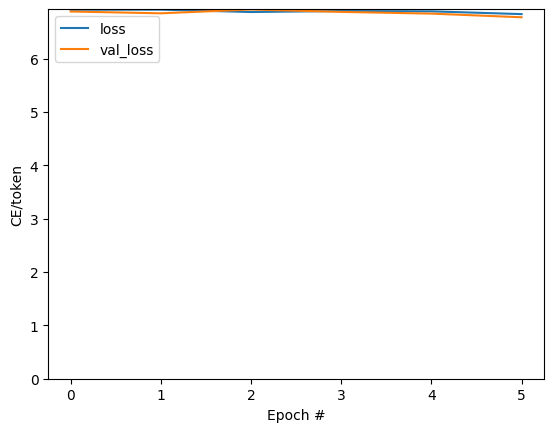

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Test the model

In [ ]:
@Summarizer.add_method
def summarize(self,
              texts, *,
              max_length=120):
  # Process the input texts
  context = self.encoder.convert_inputs(texts, mode="encode")
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(tf.reshape(attention_weights, [batch_size, -1, 1]), axis=2)  # t*[(batch s, 1)] -> (batch, s, t)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
UNITS = 256
EMB_DIM = 128

model_dir = os.path.join(project_dir, "models")
model_path = os.path.join(model_dir,"weights.best.hdf5")

summarizer = Summarizer(EMB_DIM, UNITS, article_processor, summary_processor)

In [ ]:
adagrad_opt = tf.keras.optimizers.experimental.Adagrad(
    learning_rate=0.15,
    initial_accumulator_value=0.1,
    clipnorm=2,
)

summarizer.compile(optimizer=adagrad_opt,
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [ ]:
summarizer.load_weights(model_path)

In [ ]:
summarizer.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 115s 5s/step - loss: 5.2256 - masked_acc: 0.2306 - masked_loss: 5.2277


{'loss': 5.225553035736084,
 'masked_acc': 0.23058421909809113,
 'masked_loss': 5.227725982666016}